# MRF (EC8)

In [ ]:
#from platform import python_version
#print(python_version())

Ejemplo EC. Estabilidad lateral. Calculo de deformaciones.

<div style="max-width:400px;margin-left: auto; margin-right: 0;">
<img src="frame.png" width="800">
</div>

In [1]:
import numpy as np
import handcalcs.render
import matplotlib.pyplot as plt
from math import sqrt, pi

## Definition of loads

In [2]:
%%render
#Dead Load
Q_k = 25 #kN/m
#Live Load
G_k = 30 #kN/m
#Vertical load during seismic event
E_d = Q_k + 0.3*G_k #KN/m

<IPython.core.display.Latex object>

In [3]:
%%render
#Seismic base shear
S = 1.15
T_B = 0.2 #s
T_C = 0.6 #s
T_D = 2.0 #s
a_gr = 0.45 #g
q = 5
gamma_I = 1

<IPython.core.display.Latex object>

## Inicializacion del Modelo en OpenSees

In [4]:
import openseespy.opensees as ops
import openseespy.postprocessing.ops_vis as opsv
#import openseespy as ops  # local compilation
#import opsvis as opsv

In [5]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

In [6]:
%%render
Nsto, Nbay=2, 2 #number of bays and storeys
Hsto, Wbay = 3.5, 7. #lengh of columns and beams
Hground = 3.5 #height of bottom storey
HBldg=(Nsto-1)*Hsto+Hground # height of building

<IPython.core.display.Latex object>

## Calculo de cortante basal

In [7]:
%%render
#Period estimation
C_t= 0.085
T_1 = C_t*(HBldg**(0.75))

<IPython.core.display.Latex object>

In [8]:
%%render
#Calculo de cortante T_b<T1<T_c(automatizar para diferentes rangos espectrales)
S_d = a_gr * S * 2.5 /q *9.81 #m/s2
L_lambda = 0.85 #2Tc>T1
W_storey = E_d * Nbay * Wbay #kN
W_building = W_storey * Nsto #kN
F_b = L_lambda * W_building/9.81 * S_d #kN
perc = F_b/W_building*100 #100

<IPython.core.display.Latex object>

In [9]:
%%render
#Distribucion de cortante en altura
#sum
sum = Hground*W_storey+(Hground+Hsto)*W_storey+(Hground+2*Hsto)*W_storey
#Ground floor
Px=[F_b*Hground*W_storey/sum, F_b*(Hground+Hsto)*W_storey/sum, -F_b*(Hground+2*Hsto)*W_storey/sum] #KN




<IPython.core.display.Latex object>

In [10]:
%%render
Px=[7.51, 5.75] #kN

<IPython.core.display.Latex object>

In [11]:
#Properties of sections
#Columns HEB340B and Beams IPE330, overdesigned, implement diff column section for internal columns
Acol, Agir = 171.e-4, 62.6e-4
IzCol, IzGir = 36660.e-8, 11770.e-8
E = 200.e9
#Asignacion de secciones
Ep = {1: [E, Acol, IzCol],
      2: [E, Acol, IzCol],
      3: [E, Agir, IzGir]}

In [12]:
#Nodes
#Colum bases
#ops.node(1,0.,0.)
#Bottom storey
for j in range(0, 2):
    for i in range(0, Nbay+1):
        ops.node(10*j+1+i,0.+i*Wbay,0.+j*Hground)
#Upper storeys
for j in range(2, Nsto+1):
    for i in range(0, Nbay+1):
        ops.node(10*j+1+i,0.+i*Wbay,0.+j*Hsto)
print(j), print(i)

2
2


(None, None)

In [13]:
#Fixed support
for i in range(1,Nbay+2):
    ops.fix(i, 1, 1, 1)

In [14]:
ops.geomTransf('Linear', 1)

In [15]:
# columns
for j in range(1,Nsto+1):
    for i in range(1,Nbay+2):
        ops.element('elasticBeamColumn', j*1000+i, j*10-10+i, j*10+i, Acol, E, IzCol, 1)
#ops.element('elasticBeamColumn', 1, 1, 11, Acol, E, IzCol, 1)
#ops.element('elasticBeamColumn', 2, 2, 12, Acol, E, IzCol, 1)
#ops.element('elasticBeamColumn', 3, 11, 21, Acol, E, IzCol, 1)
#ops.element('elasticBeamColumn', 4, 12, 22, Acol, E, IzCol, 1)
# girder
for j in range(1,Nsto+1):
    for i in range(1,Nbay+1):
        ops.element('elasticBeamColumn', j*10000+i, j*10+i, j*10+i+1, Agir, E, IzGir, 1)
#ops.element('elasticBeamColumn', 5, 11, 12, Agir, E, IzGir, 1)
#ops.element('elasticBeamColumn', 6, 21, 22, Agir, E, IzGir, 1)

In [16]:
#1st storey
W1y, W1x = -E_d*1000, 0.
for i in range (1,Nbay+1):
    Ew1 = {10000+i: ['-beamUniform', W1y, W1x] for i in range (1,Nbay+1)}
#2nd storey
W2y, W2x = -E_d*1000, 0.
for i in range (1,Nbay+1):
    Ew2 = {20000+i: ['-beamUniform', W2y, W2x] for i in range (1,Nbay+1)}
#3rd storey
W3y, W3x = -E_d*1000, 0.
for i in range (1,Nbay+1):
    Ew3 = {30000+i: ['-beamUniform', W3y, W3x] for i in range (1,Nbay+1)}
    

In [17]:
L_ed = np.array(Px)*1000
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
for i in range(1,Nsto):
    ops.load(10*i+1, L_ed[i-1], 0., 0.)

In [27]:
for etag in Ew1:
   ops.eleLoad('-ele', etag, '-type', Ew1[etag][0], Ew1[etag][1],Ew1[etag][2])
for etag in Ew2:
   ops.eleLoad('-ele', etag, '-type', Ew2[etag][0], Ew2[etag][1],Ew2[etag][2])
#for etag in Ew3:
#    ops.eleLoad('-ele', etag, '-type', Ew3[etag][0], Ew3[etag][1],Ew3[etag][2])

In [28]:
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')

WARNING can't set handler after analysis is created


In [29]:
ops.analyze(1)

0

In [30]:
#ops.printModel()

[7510. 5750.]
7.0


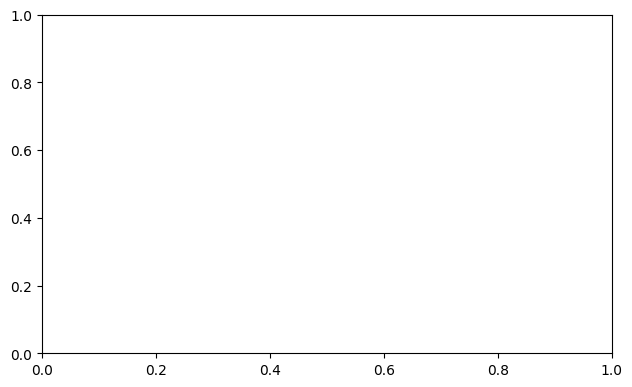

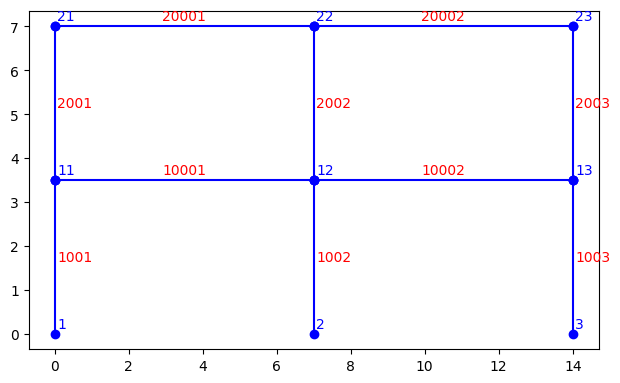

In [31]:
# 1. plot model with tag lebels

szer, wys = 16., 10.

fig = plt.figure(figsize=(szer/2.54, wys/2.54))
fig.subplots_adjust(left=.08, bottom=.08, right=.985, top=.94)
ax1 = plt.subplot(111)

opsv.plot_model()

print(L_ed)
print(HBldg)

50.0

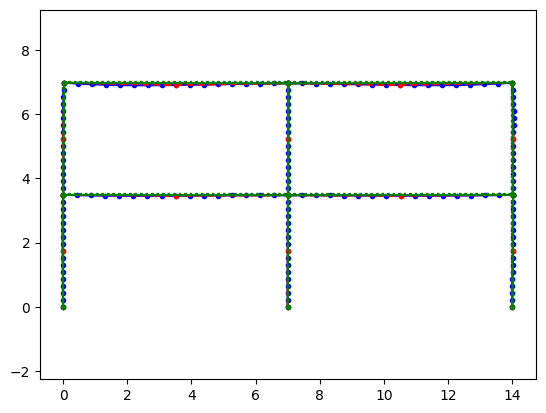

In [34]:
sfac = 5.0e1

plt.figure()
# plot_defo with optional arguments
# sfac = opsv.plot_defo()
opsv.plot_defo(sfac, fmt_interp='b.-')
opsv.plot_defo(sfac, 5, interpFlag=0, fmt_nodes='bo-')
opsv.plot_defo(sfac, 3, endDispFlag=0, fmt_interp='r.--')
opsv.plot_defo(sfac, 2, fmt_interp='g.-')

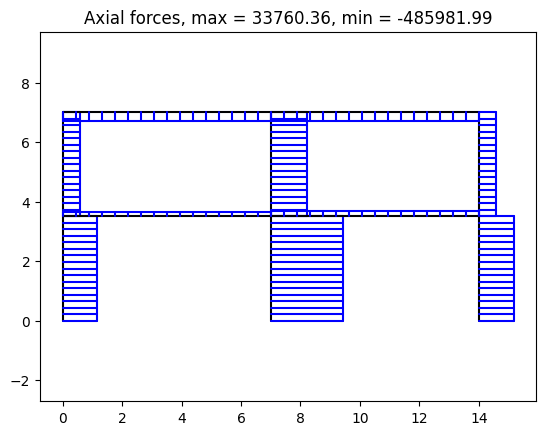

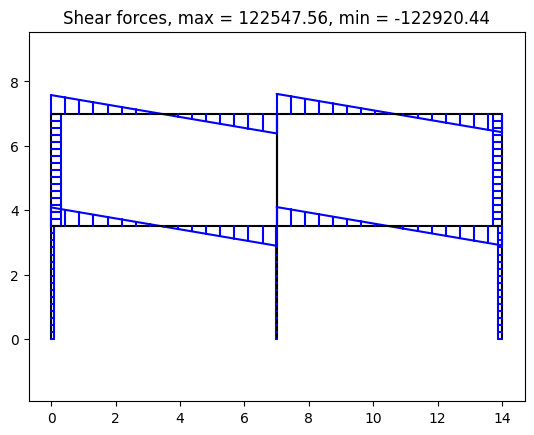

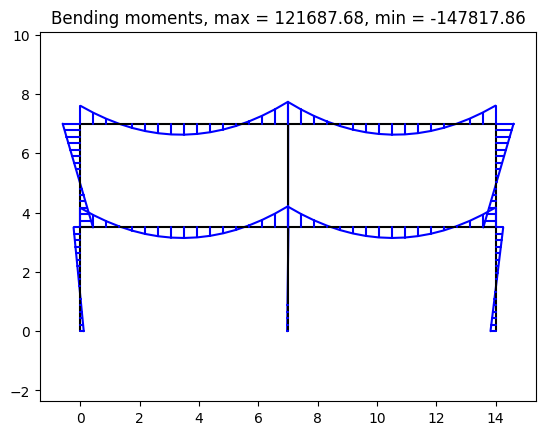

In [35]:
# print(f'sfac: {sfac}')  # return sfac if automatically calculated

# 3. plot N, V, M forces diagrams

sfacN, sfacV, sfacM = 5.e-6, 5.e-6, 5.e-6

Ew = {**Ew1, **Ew2, **Ew3}

plt.figure()
minVal, maxVal = opsv.section_force_diagram_2d('N', Ew, sfacN)
plt.title(f'Axial forces, max = {maxVal:.2f}, min = {minVal:.2f}')

plt.figure()
minVal, maxVal = opsv.section_force_diagram_2d('T', Ew, sfacV)
plt.title(f'Shear forces, max = {maxVal:.2f}, min = {minVal:.2f}')

plt.figure()
minVal, maxVal = opsv.section_force_diagram_2d('M', Ew, sfacM)
plt.title(f'Bending moments, max = {maxVal:.2f}, min = {minVal:.2f}')

plt.show()

#exit()